In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('1976-2020-president.csv')
df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


In [16]:
# Here we do a little data Wrangling to improve the dataset for analysis

# Focus on Democrats and Republicans only 
df = df[df['party_simplified'].str.contains('DEMOCRAT') | df['party_simplified'].str.contains('REPUBLICAN')]

# Calculate the two-party total votes for each state and year
df['two_party_total'] = df.groupby(['year', 'state'])['candidatevotes'].transform('sum')

# Calculate the percentage of the two-party vote afforded to each party
df['pct_2p_vote'] = 100*df['candidatevotes'] / df['two_party_total']

# define a function that returns the incumbent and whether the incumbent party is seeking their 2nd term in office
def identify_incumbent_complete(year):
    if year in [1976]:
        return ('REPUBLICAN', 0)  # Ford (Continuing Nixon's term)
    elif year in [1980]:
        return ('DEMOCRAT', 1)  # Carter
    elif year in [1984, 1988]:
        return ('REPUBLICAN', 1 if year == 1984 else 0)  # Reagan
    elif year in [1992]:
        return ('REPUBLICAN', 0)  # H.W. Bush (continuing Republican (Reagan) term)
    elif year in [1996, 2000]:
        return ('DEMOCRAT', 1 if year == 1996 else 0)  # Clinton
    elif year in [2004, 2008]:
        return ('REPUBLICAN', 1 if year == 2004 else 0)  # W. Bush
    elif year in [2012, 2016]:
        return ('DEMOCRAT', 1 if year == 2012 else 0)  # Obama
    elif year in [2020]:
        return ('REPUBLICAN', 1)  # Trump
    else:
        return ('None', 0)  # Default for years without a U.S. presidential election

# Apply the function to each row
df['incumbent_party'] = 'None'
df['term2'] = 0
for index, row in df.iterrows():
    incumbent_party, term2 = identify_incumbent_complete(row['year'])
    df.at[index, 'incumbent_party'] = incumbent_party
    df.at[index, 'term2'] = term2

# Now we can focus on the incumbent party, and focus our analysis to ask `what is the chance that the share of the vote the incmumbent will get ? 
df['incumbent_dummy'] = np.where(df['incumbent_party']==df['party_simplified'],1,0)
df = df[df['incumbent_dummy'] == 1]

# and we only need a few variables 
df = df[['year','state','pct_2p_vote','term2']]

In [17]:
# augment with national GDP data 
aux_gdp = pd.read_csv('Historical_National.US.GDP.csv')
aux_gdp = aux_gdp[aux_gdp['Items']=='Gross domestic product']

# melt 
aux_gdp = pd.melt(aux_gdp, id_vars='Items',var_name='year',value_name='real_gdp_pct_growth')
aux_gdp = aux_gdp[['year','real_gdp_pct_growth']]
aux_gdp['real_gdp_pct_growth'] = pd.to_numeric(aux_gdp['real_gdp_pct_growth'])

# merge with df 
df['year'] = df['year'].astype(int)  # Convert to int
aux_gdp['year'] = aux_gdp['year'].astype(int)  # Ensure this matches df
df = pd.merge(df, aux_gdp, on='year', how='left')

In [18]:
# augment with incumbent's approval rating
aux_app = pd.read_csv('Historical_President.Approval.Polls_Gallup.csv')
aux_app['net_approval'] = aux_app['Approving'] - aux_app['Disapproving']

# select only the approval polls right closest to the election
import pandas as pd

def last_approval_before_election(data):
    """
    Selects the last approval poll before each presidential election in the dataset.
    
    :param data: A pandas DataFrame with columns 'Start Date', 'End Date', 'Approving', 'Disapproving', 'Unsure/NoData', and 'net_approval'.
    :return: A pandas DataFrame with the selected polls.
    """
    # Convert date columns to datetime
    data['Start Date'] = pd.to_datetime(data['Start Date'])
    data['End Date'] = pd.to_datetime(data['End Date'])
    
    # Sort the data by 'End Date' to ensure chronological order
    data.sort_values(by='End Date', inplace=True)
    
    # Identify the range of years in the dataset
    start_year = data['End Date'].dt.year.min()
    end_year = data['End Date'].dt.year.max()
    
    # Presidential elections are held every 4 years, starting from 1944
    election_years = [year for year in range(start_year, end_year+1) if year % 4 == 0 and year >= 1944]
    
    selected_polls = []
    for year in election_years:
        # Election date: first Tuesday after the first Monday in November
        # Simplification: use November 1st as a base, then adjust
        base_date = pd.Timestamp(year=year, month=11, day=1)
        day_of_week = base_date.dayofweek
        election_date = base_date + pd.Timedelta(days=(1-day_of_week) % 7 + 1)
        
        # Select the last poll before the election
        last_poll = data[data['End Date'] < election_date].iloc[-1]
        selected_polls.append(last_poll)
    
    return pd.DataFrame(selected_polls)

def eight_months_before_election(data):
    """
    Selects the approval poll 8 months before each presidential election in the dataset.
    
    :param data: A pandas DataFrame with columns 'Start Date', 'End Date', 'Approving', 'Disapproving', 'Unsure/NoData', and 'net_approval'.
    :return: A pandas DataFrame with the selected polls.
    """
    # Convert date columns to datetime
    data['Start Date'] = pd.to_datetime(data['Start Date'])
    data['End Date'] = pd.to_datetime(data['End Date'])
    
    # Sort the data by 'End Date' to ensure chronological order
    data.sort_values(by='End Date', inplace=True)
    
    # Identify the range of years in the dataset
    start_year = data['End Date'].dt.year.min()
    end_year = data['End Date'].dt.year.max()
    
    # Presidential elections are held every 4 years, starting from 1944
    election_years = [year for year in range(start_year, end_year+1) if year % 4 == 0 and year >= 1944]
    
    selected_polls = []
    for year in election_years:
        # Election date: first Tuesday after the first Monday in November
        # Simplification: use November 1st as a base, then adjust
        base_date = pd.Timestamp(year=year, month=11, day=1)
        day_of_week = base_date.dayofweek
        election_date = base_date + pd.Timedelta(days=(1-day_of_week) % 7 + 1)
        
        # Select the last poll before the election
        last_poll = data[data['End Date'] < election_date - pd.Timedelta(days=8*30)].iloc[-1]
        selected_polls.append(last_poll)
    
    return pd.DataFrame(selected_polls)



# apply the function
last_app = last_approval_before_election(aux_app)

# apply the function
eight_app = eight_months_before_election(aux_app)

# extract relevant year
last_app['year'] = aux_app['End Date'].astype(str).str[:4].astype(int)

# extract relevant year
eight_app['year'] = aux_app['End Date'].astype(str).str[:4].astype(int)


# drop unnecessary variables 
last_app = last_app[['year','net_approval']]
eight_app = eight_app[['year','net_approval']]

# merge with election results dataset 
df = pd.merge(df, last_app, on='year', how='left')
df = pd.merge(df, eight_app, on='year', how='left')

In [19]:
df

,year,state,pct_2p_vote,term2,real_gdp_pct_growth,net_approval_x,net_approval_y
0,1976,ALABAMA,43.333276,0,5.4,5,10
1,1976,ALASKA,61.891829,0,5.4,5,10
2,1976,ARIZONA,58.613303,0,5.4,5,10
3,1976,ARKANSAS,34.951149,0,5.4,5,10
4,1976,CALIFORNIA,50.917827,0,5.4,5,10
...,...,...,...,...,...,...,...
609,2020,VIRGINIA,44.845313,1,-2.2,-6,-4
610,2020,WASHINGTON,40.074497,1,-2.2,-6,-4
611,2020,WEST VIRGINIA,69.798532,1,-2.2,-6,-4
612,2020,WISCONSIN,49.680937,1,-2.2,-6,-4


In [20]:
df.to_csv('clean_TFC_data.csv', index=False)

In [22]:
import pandas as pd
import statsmodels.api as sm

# Define your design matrix and your target variable 

# Create dummy variables for 'state' column correctly
state_dummies = pd.get_dummies(df['state'], prefix='state', drop_first=True)

# Concatenate the dummy variables with the DataFrame
temp = pd.concat([df, state_dummies], axis=1)

# Specify the columns to be included in X. Ensure all are numeric
X = temp[['term2', 'real_gdp_pct_growth', 'net_approval_x', 'net_approval_y'] + 
         state_dummies.columns.tolist()].astype(float) 
y = temp['pct_2p_vote']

# Add a constant to the features to account for the intercept in the model
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            pct_2p_vote   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.441
Date:                Tue, 06 Feb 2024   Prob (F-statistic):             0.0250
Time:                        16:03:58   Log-Likelihood:                -2322.2
No. Observations:                 614   AIC:                             4754.
Df Residuals:                     559   BIC:                             4997.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Per state regression

In [24]:
#loop through states and save the rsquared
rsquared = {}
#filter the df to only include the states
states = df['state'].unique()
for state in states:
    temp = df[df['state'] == state]
    X = temp[['term2', 'real_gdp_pct_growth', 'net_approval_x', 'net_approval_y']].astype(float)
    y = temp['pct_2p_vote']
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    rsquared[state] = model.rsquared

# Create a DataFrame from the dictionary
rsquared_df = pd.DataFrame(pd.Series(rsquared), columns=['R-squared'])
rsquared_df = rsquared_df.sort_values(by='R-squared', ascending=False)
rsquared_df

,R-squared
NEW MEXICO,0.917599
COLORADO,0.901334
NEVADA,0.895683
MICHIGAN,0.890131
WISCONSIN,0.875534
NEW HAMPSHIRE,0.869592
PENNSYLVANIA,0.851007
NEW JERSEY,0.779272
CONNECTICUT,0.771873
VIRGINIA,0.743325


### Predictions

In [10]:
import statsmodels.api as sm

# Step 1: Prepare the new dataset - remember to add a constant if your model includes an intercept
X_new = X
X_new_with_const = sm.add_constant(X_new) 

# Step 2: Predict new values
new_predictions = model.predict(X_new_with_const)

# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = X_new_with_const
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)

# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  # Convert to numpy array and add new axis
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  # Convert to numpy array and add new axis

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000))

monte_carlo_medians = np.median(predicted_samples, axis=1)
prediction_intervals = np.percentile(predicted_samples, [2.5, 97.5], axis=1)


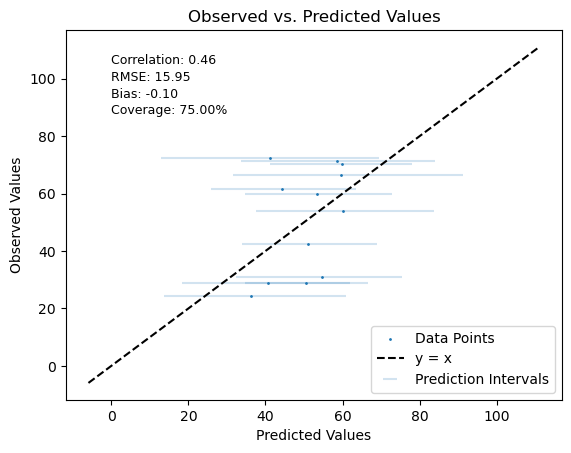

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)  # Mean prediction error
coverage = np.mean((y >= prediction_intervals[0,:]) & (y <= prediction_intervals[1,:]))

# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_samples_flat = predicted_samples.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_samples_flat, y])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()
